<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IPython-Features" data-toc-modified-id="IPython-Features-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IPython Features</a></span><ul class="toc-item"><li><span><a href="#Restrict-notebooks" data-toc-modified-id="Restrict-notebooks-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Restrict notebooks</a></span></li><li><span><a href="#Features" data-toc-modified-id="Features-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Features</a></span><ul class="toc-item"><li><span><a href="#magic" data-toc-modified-id="magic-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>magic</a></span></li><li><span><a href="#run_line_magic" data-toc-modified-id="run_line_magic-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>run_line_magic</a></span></li><li><span><a href="#magic-+-run_line_magic" data-toc-modified-id="magic-+-run_line_magic-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>magic + run_line_magic</a></span></li><li><span><a href="#output_ref" data-toc-modified-id="output_ref-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>output_ref</a></span></li><li><span><a href="#run_cell_magic" data-toc-modified-id="run_cell_magic-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>run_cell_magic</a></span></li><li><span><a href="#system" data-toc-modified-id="system-1.2.6"><span class="toc-item-num">1.2.6&nbsp;&nbsp;</span>system</a></span></li><li><span><a href="#getoutput" data-toc-modified-id="getoutput-1.2.7"><span class="toc-item-num">1.2.7&nbsp;&nbsp;</span>getoutput</a></span></li><li><span><a href="#system-+-getoutput-by-notebook" data-toc-modified-id="system-+-getoutput-by-notebook-1.2.8"><span class="toc-item-num">1.2.8&nbsp;&nbsp;</span>system + getoutput by notebook</a></span></li><li><span><a href="#input_ref" data-toc-modified-id="input_ref-1.2.9"><span class="toc-item-num">1.2.9&nbsp;&nbsp;</span>input_ref</a></span></li><li><span><a href="#set_next_input" data-toc-modified-id="set_next_input-1.2.10"><span class="toc-item-num">1.2.10&nbsp;&nbsp;</span>set_next_input</a></span></li><li><span><a href="#set_hook" data-toc-modified-id="set_hook-1.2.11"><span class="toc-item-num">1.2.11&nbsp;&nbsp;</span>set_hook</a></span></li><li><span><a href="#shadown_ref" data-toc-modified-id="shadown_ref-1.2.12"><span class="toc-item-num">1.2.12&nbsp;&nbsp;</span>shadown_ref</a></span></li></ul></li></ul></li></ul></div>

# IPython Features

Analyze Ipython Features: magics, bang expressions, output and input references.

In [1]:
import sys

sys.path.insert(0, "../archaeology")
sys.path.insert(0, "../analysis")
import importlib
from collections import Counter

import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from db import connect
import analysis_helpers

importlib.reload(analysis_helpers)
from analysis_helpers import calculate_auto, close_fig, display_counts, savefig

%matplotlib inline

In [2]:
with connect() as session:
    # print('Last query:', session.query(Query).all()[-1])
    raw_features = pd.read_sql_table("notebook_features", session.connection())
    print("Features:", len(raw_features))

Features: 20690


In [3]:
columns = [
    "shadown_ref",
    "output_ref",
    "system",
    "set_next_input",
    "input_ref",
    "magic",
    "run_line_magic",
    "run_cell_magic",
    "getoutput",
    "set_hook",
]
count_columns = [c + "_count" for c in columns]
for column in columns:
    raw_features[column] = raw_features[column].apply(lambda c: set(c.split(",")))

In [4]:
raw_features.head(5)

,id,repository_id,notebook_id,index,index_count,any,any_count,shadown_ref,shadown_ref_count,output_ref,...,run_line_magic,run_line_magic_count,run_cell_magic,run_cell_magic_count,getoutput,getoutput_count,set_hook,set_hook_count,others,skip
0,1,6,2,"12,54,61",3,"echo,cat,_,__",4,{},0,"{__, _}",...,{},0,{},0,{},0,{},0,,0
1,2,8,3,"1,2,3,9,29,30",6,"pip,git,tar,mkdir,for",5,{},0,{},...,{},0,{},0,{},0,{},0,,0
2,3,8,4,"1,2",2,pip,1,{},0,{},...,{},0,{},0,{},0,{},0,,0
3,4,8,5,"1,2,3,9,32,33",6,"pip,git,tar,mkdir,for",5,{},0,{},...,{},0,{},0,{},0,{},0,,0
4,5,8,6,"1,2",2,pip,1,{},0,{},...,{},0,{},0,{},0,{},0,,0


## Restrict notebooks

In [5]:
SKIP_MAP = {
    "f_": 1024 + 512,
    "d_": 1024 + 512 + 128,
    "dt_": 1024 + 512 + 128 + 32,
    "dr_": 1024 + 512 + 128 + 64,
}

CONFIG = {
    "Default": "f_",
    "Remove duplicates": "d_",
    "Remove duplicates and toy": "dt_",
    "Remove duplicates and restricted toy": "dr_",
}

In [6]:
@calculate_auto(CONFIG, save_to="features", level=None)
def func(prefix=""):
    return raw_features[
        np.bitwise_and(raw_features["skip"], SKIP_MAP[prefix]) == 0
    ].copy()

## Features


Currently, we only have IPython features

* IPython/magic: `%example`
* IPython/run_line_magic: `%example`
* IPython/output_ref: `_2`, `Out[3]`
* IPython/run_cell_magic: `%%timeit`
* IPython/system: `!ls`
* IPython/getoutput: `x = !ls`
* IPython/input_ref: `In[2]`
* IPython/set_next_input: `a = x??`

* IPython/shadown_ref: `_sh`


False positives


* IPython/set_hook: `get_ipython().set_hook()`


In [7]:
@calculate_auto(CONFIG, save_to="count", result=None, level=None)
def fn(features, prefix):
    count = (
        features[count_columns]
        .sum()
        .rename(lambda x: x[:-6])
        .sort_values(ascending=False)
    )
    return count

### Default

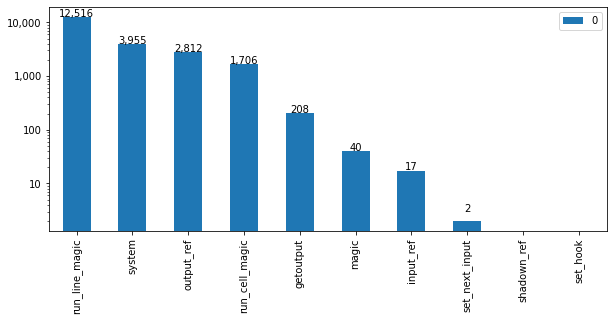

,0
run_line_magic,12516
system,3955
output_ref,2812
run_cell_magic,1706
getoutput,208
magic,40
input_ref,17
set_next_input,2
shadown_ref,0
set_hook,0


<Figure size 432x288 with 0 Axes>

### Remove duplicates

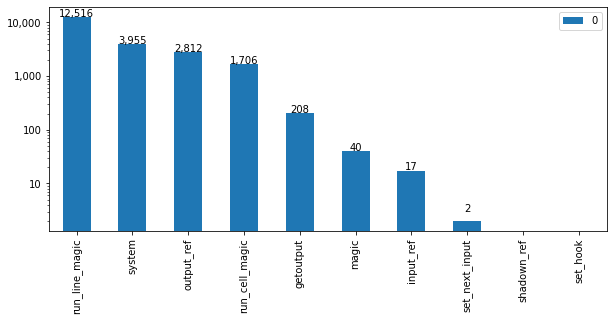

,0
run_line_magic,12516
system,3955
output_ref,2812
run_cell_magic,1706
getoutput,208
magic,40
input_ref,17
set_next_input,2
shadown_ref,0
set_hook,0


<Figure size 432x288 with 0 Axes>

### Remove duplicates and toy

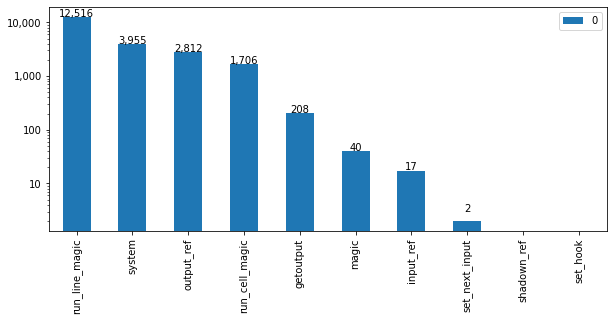

,0
run_line_magic,12516
system,3955
output_ref,2812
run_cell_magic,1706
getoutput,208
magic,40
input_ref,17
set_next_input,2
shadown_ref,0
set_hook,0


<Figure size 432x288 with 0 Axes>

### Remove duplicates and restricted toy

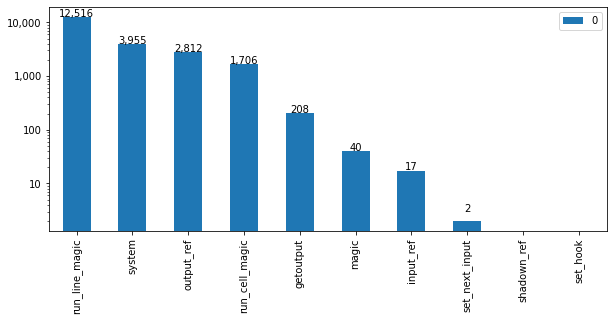

,0
run_line_magic,12516
system,3955
output_ref,2812
run_cell_magic,1706
getoutput,208
magic,40
input_ref,17
set_next_input,2
shadown_ref,0
set_hook,0


<Figure size 432x288 with 0 Axes>

In [8]:
@calculate_auto(CONFIG)
@close_fig
def fn(count, prefix):
    display_counts(count, width=10, show_values=True)

### magic

`%matplotlib inline`

### Default

,0
autoreload,17
load_ext,17
matplotlib,4
pylab,2


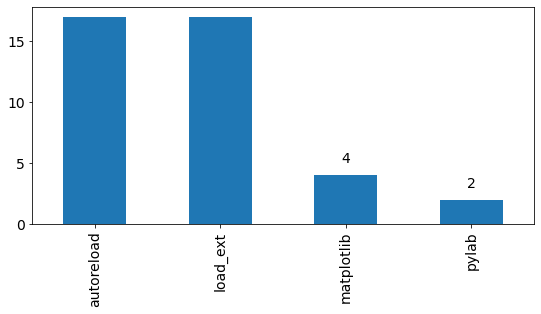

### Remove duplicates

,0
autoreload,17
load_ext,17
matplotlib,4
pylab,2


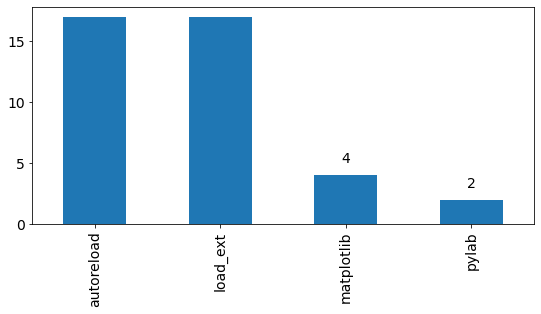

### Remove duplicates and toy

,0
autoreload,17
load_ext,17
matplotlib,4
pylab,2


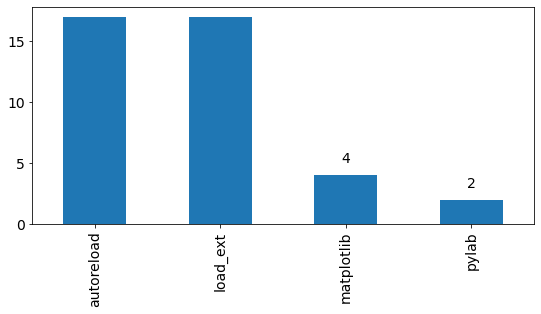

### Remove duplicates and restricted toy

,0
autoreload,17
load_ext,17
matplotlib,4
pylab,2


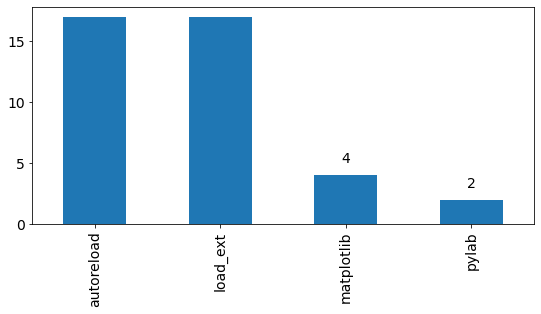

In [9]:
@calculate_auto(CONFIG)
@close_fig
def fn(features, prefix):
    counter = Counter()
    features["magic"].agg(lambda x: counter.update(x))
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    with savefig(prefix + "notebook_feature_magic", 9, 4):
        fig, cnt = display_counts(
            counts,
            width=20,
            show_values=True,
            plot=False,
            cut=slice(None, 10),
            logy=False,
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)

### run_line_magic

`%matplotlib inline`

### Default

,0
matplotlib,5903
load_ext,2035
autoreload,1801
config,368
run,315
reload_ext,292
env,255
time,242
pylab,201
watermark,149


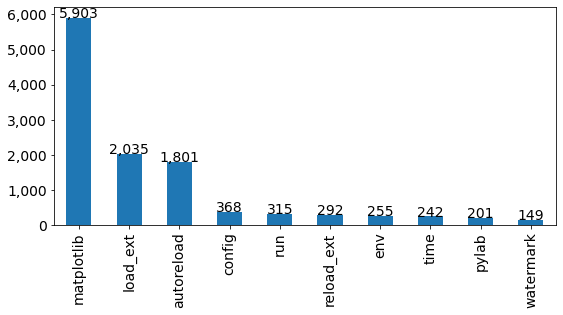

### Remove duplicates

,0
matplotlib,5903
load_ext,2035
autoreload,1801
config,368
run,315
reload_ext,292
env,255
time,242
pylab,201
watermark,149


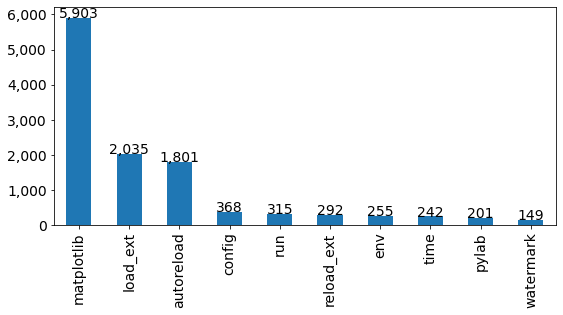

### Remove duplicates and toy

,0
matplotlib,5903
load_ext,2035
autoreload,1801
config,368
run,315
reload_ext,292
env,255
time,242
pylab,201
watermark,149


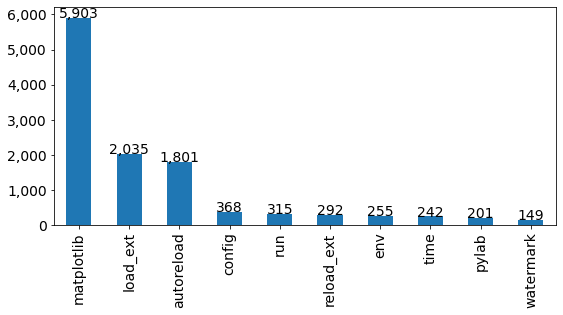

### Remove duplicates and restricted toy

,0
matplotlib,5903
load_ext,2035
autoreload,1801
config,368
run,315
reload_ext,292
env,255
time,242
pylab,201
watermark,149


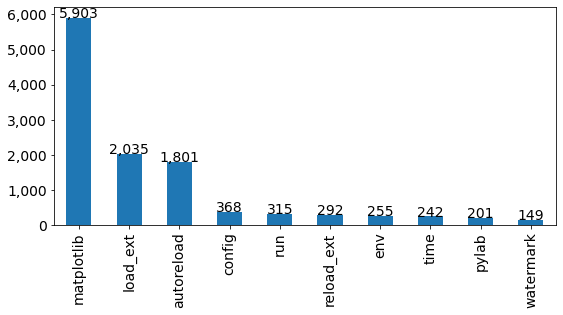

In [10]:
@calculate_auto(CONFIG)
@close_fig
def fn(features, prefix):
    counter = Counter()
    features["run_line_magic"].agg(lambda x: counter.update(x))
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    with savefig(prefix + "notebook_feature_run_line_magic", 9, 4):
        fig, cnt = display_counts(
            counts,
            width=20,
            show_values=True,
            plot=False,
            cut=slice(None, 10),
            logy=False,
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)

### magic + run_line_magic

`%matplotlib inline`

In [11]:
""" @calculate_auto(CONFIG, save_to="counter", result=None)
@close_fig
def fn(features, prefix):
    counter = Counter()
    np.bitwise_or(features["magic"], features["run_line_magic"]).agg(
        lambda x: counter.update(x)
    ).agg(lambda x: counter.update(x))
    del counter['']
    counts = pd.Series(counter).sort_values(ascending=False)
    with savefig(prefix + "notebook_feature_line_magic", 9, 4):
        fig, cnt = display_counts(
            counts, width=20, show_values=True, plot=False,
            cut=slice(None, 10), logy=False
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)
    return counter """

' @calculate_auto(CONFIG, save_to="counter", result=None)\n@close_fig\ndef fn(features, prefix):\n    counter = Counter()\n    np.bitwise_or(features["magic"], features["run_line_magic"]).agg(\n        lambda x: counter.update(x)\n    ).agg(lambda x: counter.update(x))\n    del counter[\'\']\n    counts = pd.Series(counter).sort_values(ascending=False)\n    with savefig(prefix + "notebook_feature_line_magic", 9, 4):\n        fig, cnt = display_counts(\n            counts, width=20, show_values=True, plot=False,\n            cut=slice(None, 10), logy=False\n        )\n        display(cnt)\n        ax = plt.gca()\n        ax.legend().set_visible(False)\n    return counter '

In [12]:
""" @calculate_auto(CONFIG)
def fn(features, counter, prefix):
    return relative_var(prefix + "ipython_matplotlib", counter["matplotlib"], len(features)) """

' @calculate_auto(CONFIG)\ndef fn(features, counter, prefix):\n    return relative_var(prefix + "ipython_matplotlib", counter["matplotlib"], len(features)) '

In [13]:
""" @calculate_auto(CONFIG)
def fn(features, counter, prefix):
    five_percent = 0.05 * len(features)
    return var(
        prefix + 'ipython_other_line_check',
        "5%" if all(
            v < five_percent for k, v in counter.items()
            if k != "matplotlib"
        ) else "<recheck 5%>"
    ) """

' @calculate_auto(CONFIG)\ndef fn(features, counter, prefix):\n    five_percent = 0.05 * len(features)\n    return var(\n        prefix + \'ipython_other_line_check\',\n        "5%" if all(\n            v < five_percent for k, v in counter.items()\n            if k != "matplotlib"\n        ) else "<recheck 5%>"\n    ) '

### output_ref

`x = _`

### Default

,0
_,2766
__,9
_1,7
_2,6
_3,6
_4,6
_0,6
Out[],2
_1945,1
_1946,1


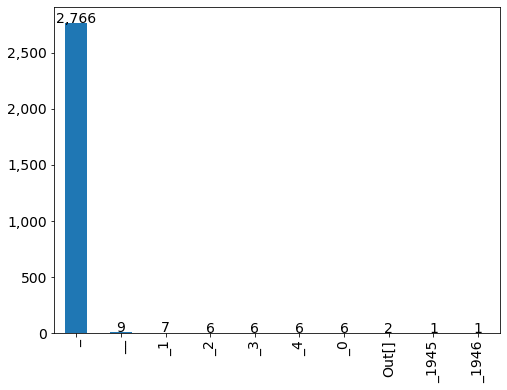

### Remove duplicates

,0
_,2766
__,9
_1,7
_2,6
_3,6
_4,6
_0,6
Out[],2
_1945,1
_1946,1


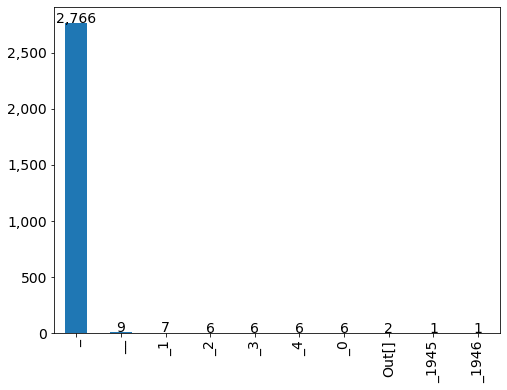

### Remove duplicates and toy

,0
_,2766
__,9
_1,7
_2,6
_3,6
_4,6
_0,6
Out[],2
_1945,1
_1946,1


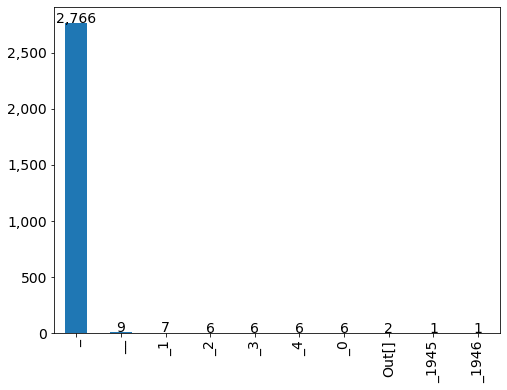

### Remove duplicates and restricted toy

,0
_,2766
__,9
_1,7
_2,6
_3,6
_4,6
_0,6
Out[],2
_1945,1
_1946,1


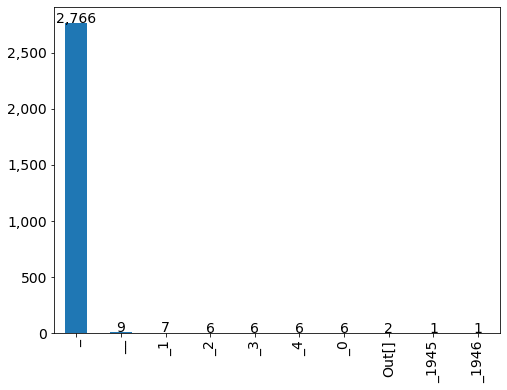

In [14]:
@calculate_auto(CONFIG)
@close_fig
def fn(features, prefix):
    counter = Counter()
    features["output_ref"].agg(lambda x: counter.update(x))
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    with savefig(prefix + "notebook_feature_output_ref", 8, 6):
        fig, cnt = display_counts(
            counts,
            width=20,
            show_values=True,
            plot=False,
            cut=slice(None, 10),
            logy=False,
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)

### run_cell_magic

`
%%time
2**1000000
`

### Default

,0
time,589
R,282
bash,264
capture,184
appyter,108
javascript,75
timeit,36
writefile,25
html,13
file,11


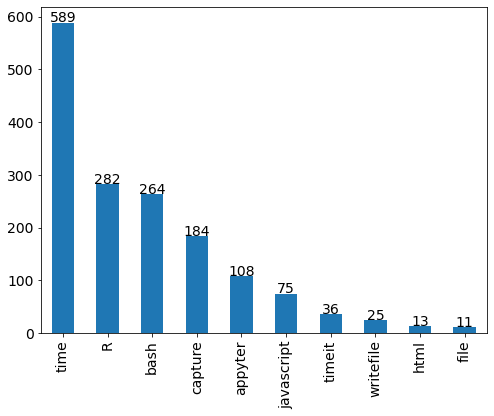

### Remove duplicates

,0
time,589
R,282
bash,264
capture,184
appyter,108
javascript,75
timeit,36
writefile,25
html,13
file,11


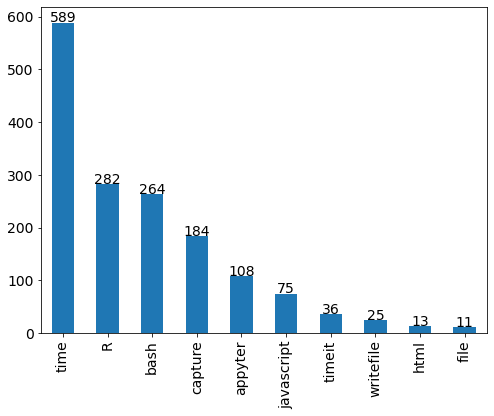

### Remove duplicates and toy

,0
time,589
R,282
bash,264
capture,184
appyter,108
javascript,75
timeit,36
writefile,25
html,13
file,11


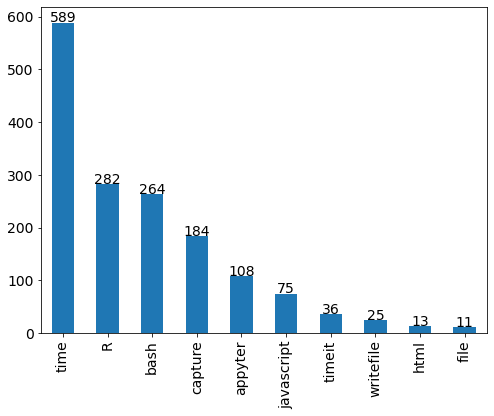

### Remove duplicates and restricted toy

,0
time,589
R,282
bash,264
capture,184
appyter,108
javascript,75
timeit,36
writefile,25
html,13
file,11


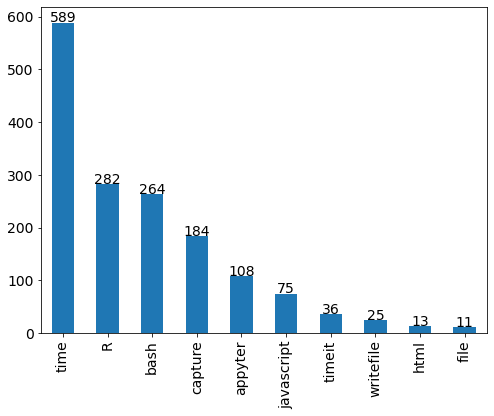

In [15]:
@calculate_auto(CONFIG)
@close_fig
def fn(features, prefix):
    counter = Counter()
    features["run_cell_magic"].agg(lambda x: counter.update(x))
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    with savefig(prefix + "notebook_feature_run_cell_magic", 8, 6):
        fig, cnt = display_counts(
            counts,
            width=20,
            show_values=True,
            plot=False,
            cut=slice(None, 10),
            logy=False,
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)

### system

`!ls`

### Default

,0
pip,616
ls,255
wget,208
mkdir,182
cat,163
git,139
date,115
head,97
python,96
rm,93


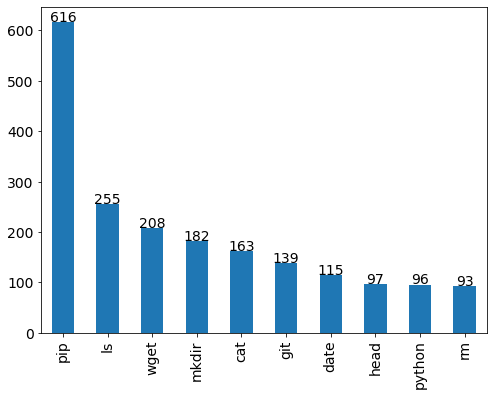

### Remove duplicates

,0
pip,616
ls,255
wget,208
mkdir,182
cat,163
git,139
date,115
head,97
python,96
rm,93


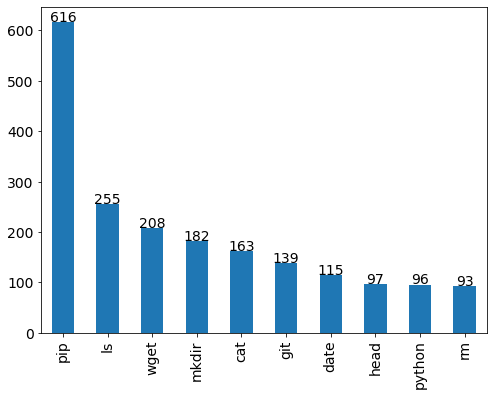

### Remove duplicates and toy

,0
pip,616
ls,255
wget,208
mkdir,182
cat,163
git,139
date,115
head,97
python,96
rm,93


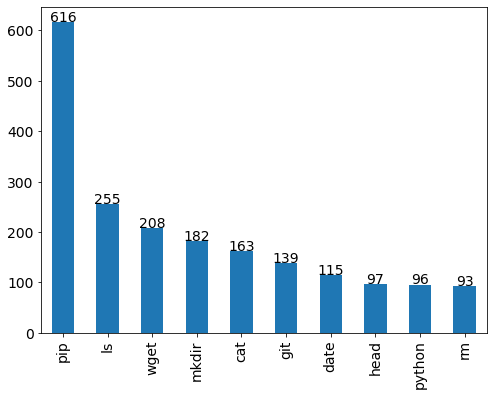

### Remove duplicates and restricted toy

,0
pip,616
ls,255
wget,208
mkdir,182
cat,163
git,139
date,115
head,97
python,96
rm,93


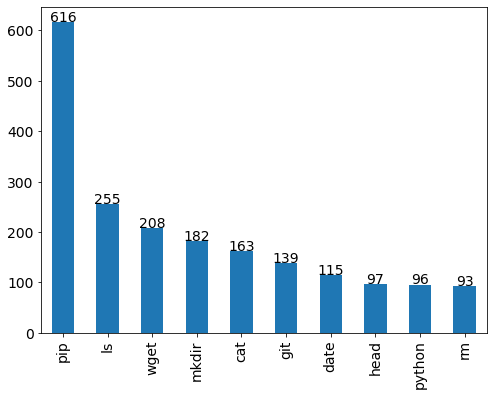

In [16]:
@calculate_auto(CONFIG)
@close_fig
def fn(features, prefix):
    counter = Counter()
    features["system"].agg(lambda x: counter.update(x))
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    with savefig(prefix + "notebook_feature_system", 8, 6):
        fig, cnt = display_counts(
            counts,
            width=20,
            show_values=True,
            plot=False,
            cut=slice(None, 10),
            logy=False,
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)

### getoutput

`x = !ls`

### Default

,0
ls,30
dms2_logoplot,21
dms2_batch_bcsubamp,16
pip,12
pwd,9
python,8
../Overlapping-NMI/onmi,7
$root/bin/bedtools,7
dms2_batch_prefs,7
dms2_batch_diffsel,7


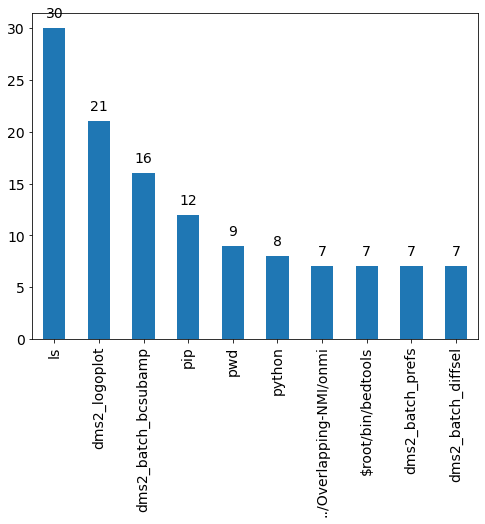

### Remove duplicates

,0
ls,30
dms2_logoplot,21
dms2_batch_bcsubamp,16
pip,12
pwd,9
python,8
../Overlapping-NMI/onmi,7
$root/bin/bedtools,7
dms2_batch_prefs,7
dms2_batch_diffsel,7


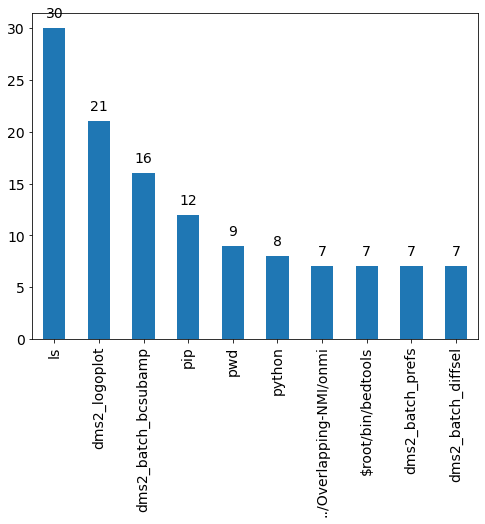

### Remove duplicates and toy

,0
ls,30
dms2_logoplot,21
dms2_batch_bcsubamp,16
pip,12
pwd,9
python,8
../Overlapping-NMI/onmi,7
$root/bin/bedtools,7
dms2_batch_prefs,7
dms2_batch_diffsel,7


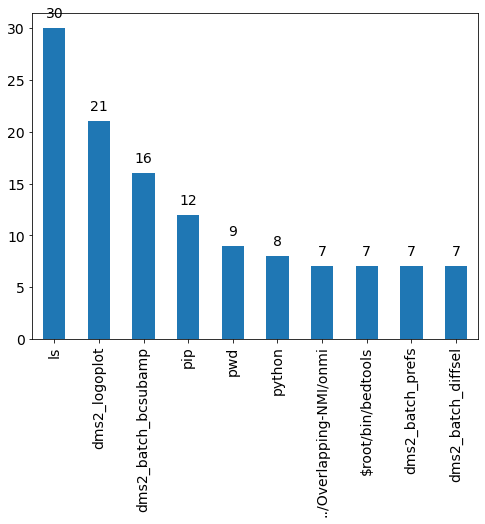

### Remove duplicates and restricted toy

,0
ls,30
dms2_logoplot,21
dms2_batch_bcsubamp,16
pip,12
pwd,9
python,8
../Overlapping-NMI/onmi,7
$root/bin/bedtools,7
dms2_batch_prefs,7
dms2_batch_diffsel,7


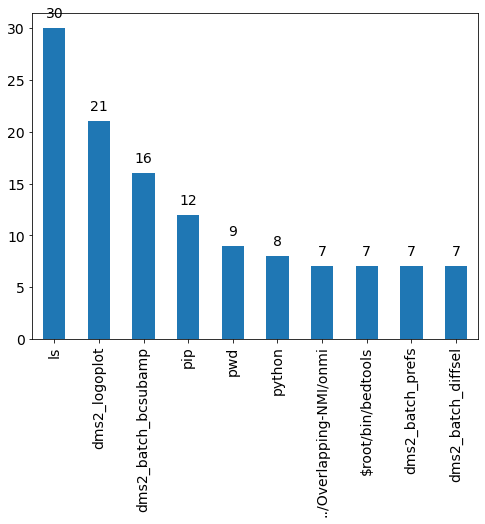

In [17]:
@calculate_auto(CONFIG)
@close_fig
def fn(features, prefix):
    counter = Counter()
    features["getoutput"].agg(lambda x: counter.update(x))
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    with savefig(prefix + "notebook_feature_getoutput", 8, 6):
        fig, cnt = display_counts(
            counts,
            width=20,
            show_values=True,
            plot=False,
            cut=slice(None, 10),
            logy=False,
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)

### system + getoutput by notebook

### Default

,0
True,20690


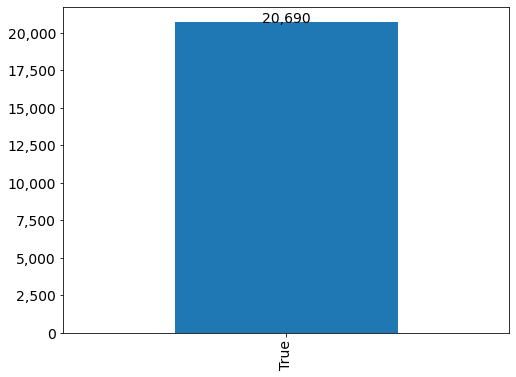

### Remove duplicates

,0
True,20690


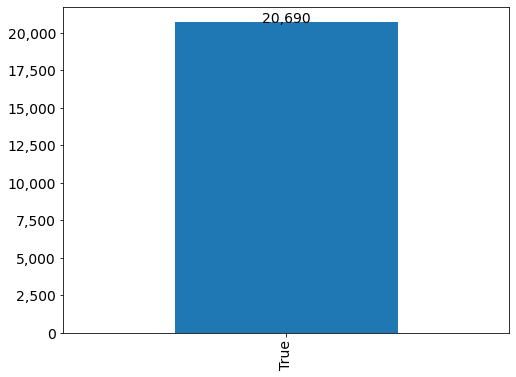

### Remove duplicates and toy

,0
True,20690


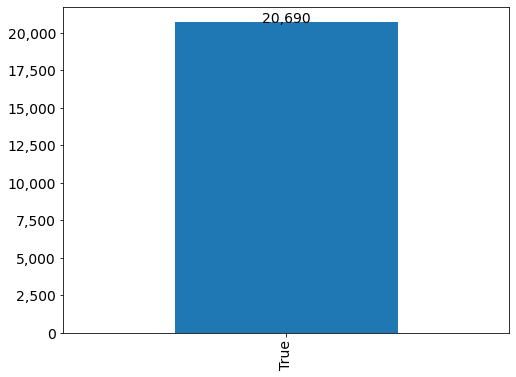

### Remove duplicates and restricted toy

,0
True,20690


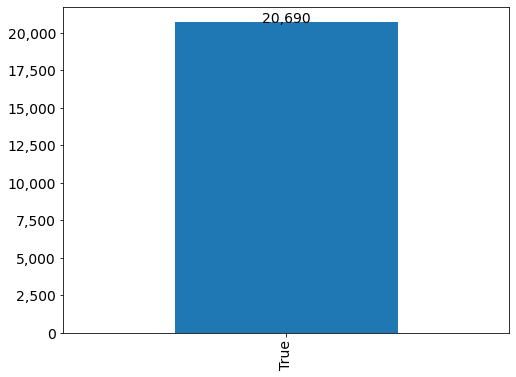

In [18]:
@calculate_auto(CONFIG)
@close_fig
def fn(features, prefix):
    counter = Counter()
    np.bitwise_or(features["system"], features["getoutput"]).agg(
        lambda x: counter.update(x)
    )
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    with savefig(prefix + "notebook_feature_bang", 8, 6):
        fig, cnt = display_counts(
            counts,
            width=20,
            show_values=True,
            plot=False,
            cut=slice(None, 10),
            logy=False,
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)

### input_ref

`x = _i`

### Default

,0
In[],9
_i,8


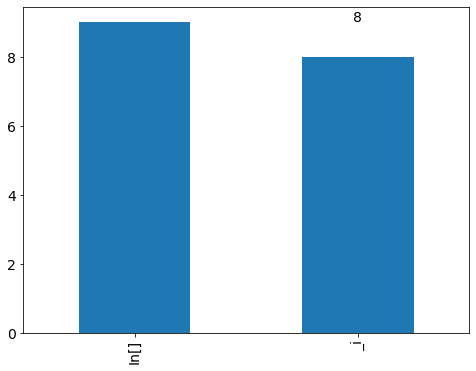

### Remove duplicates

,0
In[],9
_i,8


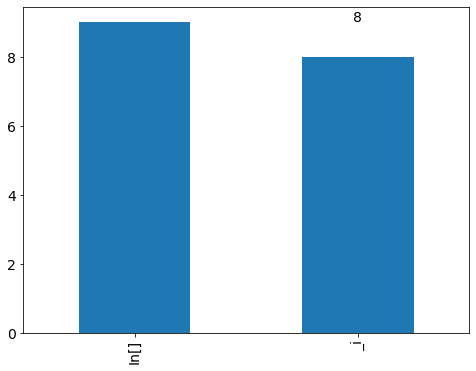

### Remove duplicates and toy

,0
In[],9
_i,8


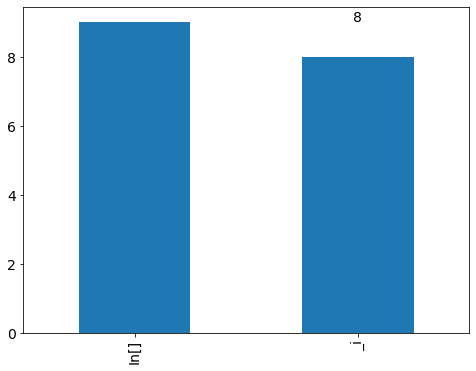

### Remove duplicates and restricted toy

,0
In[],9
_i,8


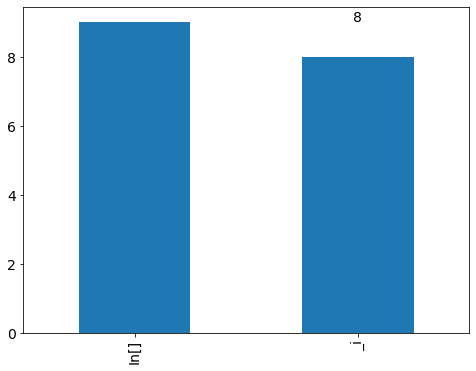

In [19]:
@calculate_auto(CONFIG)
@close_fig
def fn(features, prefix):
    counter = Counter()
    features["input_ref"].agg(lambda x: counter.update(x))
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    with savefig(prefix + "notebook_feature_input_ref", 8, 6):
        fig, cnt = display_counts(
            counts,
            width=20,
            show_values=True,
            plot=False,
            cut=slice(None, 10),
            logy=False,
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)

### set_next_input

Help, when the line contains more than the help expression

`a = x??`

### Default

,0
rich.loc[[96,1
tempgen,1


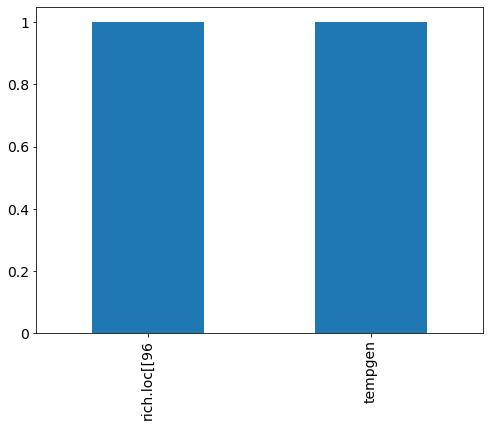

### Remove duplicates

,0
rich.loc[[96,1
tempgen,1


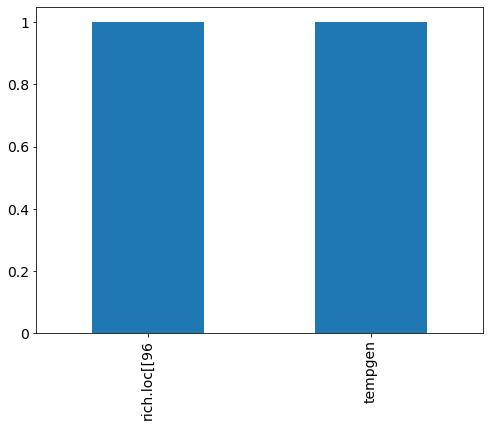

### Remove duplicates and toy

,0
rich.loc[[96,1
tempgen,1


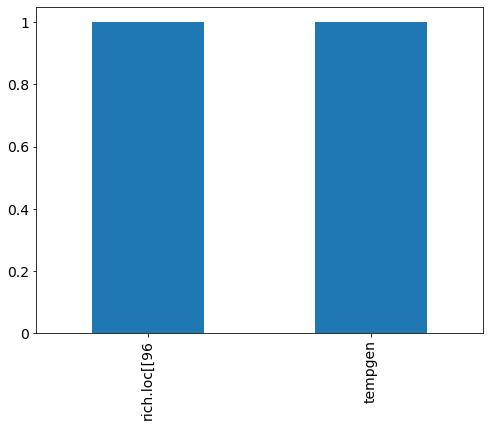

### Remove duplicates and restricted toy

,0
rich.loc[[96,1
tempgen,1


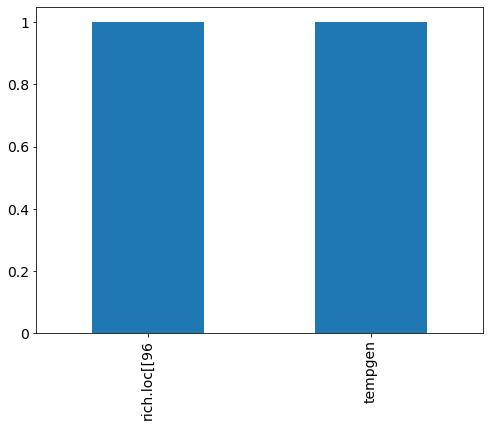

In [20]:
@calculate_auto(CONFIG)
@close_fig
def fn(features, prefix):
    counter = Counter()
    features["set_next_input"].agg(lambda x: counter.update(x))
    del counter[""]
    counts = pd.Series(counter).sort_values(ascending=False)
    with savefig(prefix + "notebook_feature_set_next_input", 8, 6):
        fig, cnt = display_counts(
            counts,
            width=20,
            show_values=True,
            plot=False,
            cut=slice(None, 10),
            logy=False,
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)

### set_hook

False positive <br>
`get_ipython().set_hook()`

In [21]:
""" @calculate_auto(CONFIG)
@close_fig
def fn(features, prefix):
    counter = Counter()
    features["set_hook"].agg(lambda x: counter.update(x))
    del counter['']
    counts = pd.Series(counter).sort_values(ascending=False)
    #with savefig(prefix + "notebook_feature_set_hook", 8, 6):
    fig, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False) """

' @calculate_auto(CONFIG)\n@close_fig\ndef fn(features, prefix):\n    counter = Counter()\n    features["set_hook"].agg(lambda x: counter.update(x))\n    del counter[\'\']\n    counts = pd.Series(counter).sort_values(ascending=False)\n    #with savefig(prefix + "notebook_feature_set_hook", 8, 6):\n    fig, cnt = display_counts(\n        counts, width=20, show_values=True, plot=False,\n        cut=slice(None, 10), logy=False\n    )\n    display(cnt)\n    ax = plt.gca()\n    ax.legend().set_visible(False) '

### shadown_ref

`_sh`

In [22]:
""" @calculate_auto(CONFIG)
@close_fig
def fn(features, prefix):
    counter = Counter()
    features["shadown_ref"].agg(lambda x: counter.update(x))
    del counter['']
    counts = pd.Series(counter).sort_values(ascending=False)
    #with savefig(prefix + "notebook_feature_shadown_ref", 8, 6):
    fig, cnt = display_counts(
        counts, width=20, show_values=True, plot=False,
        cut=slice(None, 10), logy=False
    )
    display(cnt)
    ax = plt.gca()
    ax.legend().set_visible(False) """

' @calculate_auto(CONFIG)\n@close_fig\ndef fn(features, prefix):\n    counter = Counter()\n    features["shadown_ref"].agg(lambda x: counter.update(x))\n    del counter[\'\']\n    counts = pd.Series(counter).sort_values(ascending=False)\n    #with savefig(prefix + "notebook_feature_shadown_ref", 8, 6):\n    fig, cnt = display_counts(\n        counts, width=20, show_values=True, plot=False,\n        cut=slice(None, 10), logy=False\n    )\n    display(cnt)\n    ax = plt.gca()\n    ax.legend().set_visible(False) '